# Project: ML - Linear Regression (Predicting Stock Market values)

<br>

## Questions to address:
- Predict stock value from historical data

<br>

## Tools:
- Models:
  - Linear Regression 
- Error Metric: MSE and MAE
- Holdout Validation 

<br>

### load defaults

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: Historical data for a stock index

In [10]:
df = pd.read_csv('./data/sphist.csv')

#covert date to datetime object
df['Date'] = pd.to_datetime(df['Date'])
#sort df by date in ascending order
df.sort_values('Date', ascending=True, inplace=True)
#re-index
df = df.reset_index(drop=True)

display(df[df['Date']>datetime(year=2015, month=11, day=1)].iloc[:5])

,Date,Open,High,Low,Close,Volume,Adj Close
16565,2015-11-02,2080.760010,2106.199951,2080.760010,2104.050049,3.760020e+09,2104.050049
16566,2015-11-03,2102.629883,2116.479980,2097.510010,2109.790039,4.272060e+09,2109.790039
16567,2015-11-04,2110.600098,2114.590088,2096.979980,2102.310059,4.078870e+09,2102.310059
16568,2015-11-05,2101.679932,2108.780029,2090.409912,2099.929932,4.051890e+09,2099.929932
16569,2015-11-06,2098.600098,2101.909912,2083.739990,2099.199951,4.369020e+09,2099.199951


- data on stocks is not independent (depends on previous values)
- extra careful to not inject future knowledge into past rows (algorithm will look very good on trainning set, but fail on test)
- we can create indicators to make the model more accurate (e.g. average price for the last 10 trades): information from multiple rows

- interesting indicators:
  - 5 day average, 30 day average, 365 day average
  - 5 day average / 365 day average
  - std(5 day average), std(365 day average)
  - std(5 day average) / std(365 day average)
- price is the close column

In [11]:
#for idx, row in df.iterrows():
#    df['day_5'].iloc[idx] = pd.rolling_mean(df['Close'], 5)
      
#rolling mean uses the current day price so we need to roll forward
df['avg_5'] = df['Close'].rolling(window=5, center=False).mean().shift(1)
df['avg_30'] = df['Close'].rolling(window=30, center=False).mean().shift(1)
df['avg_365'] = df['Close'].rolling(window=365, center=False).mean().shift(1)
df['avg_5_over_365'] = df['Close'].rolling(window=5, center=False).mean().shift(1)/df['Close'].rolling(window=365, center=False).mean().shift(1)
df['std_5'] = df['Close'].rolling(window=5, center=False).std().shift(1)
df['std_365'] = df['Close'].rolling(window=365, center=False).std().shift(1)
df['std_5_over_365'] = df['Close'].rolling(window=5, center=False).std().shift(1)/df['Close'].rolling(window=365, center=False).std().shift(1)
#print(df.iloc[365])

#remove NaN, rows where the index could not be calculated 
#(in the first year, there are not enough rows to compute year average)
print("Len with Nans: {:d}".format(len(df)))
df.dropna(how='any', inplace=True, axis=0)
print("Len without Nans: {:d}".format(len(df)))

Len with Nans: 16590
Len without Nans: 16225


In [12]:
#create train and test (train everything before 2013-01-01)
train = df[df['Date']<datetime(year=2013, month=1, day=1)]
test = df[df['Date']>=datetime(year=2013, month=1, day=1)]
print(len(train), len(test))

15486 739


<br>

### Error metric: MAE (easier to interpret) or MSE (better, but harder to intuitively know how far the model is)

16.267878754475266


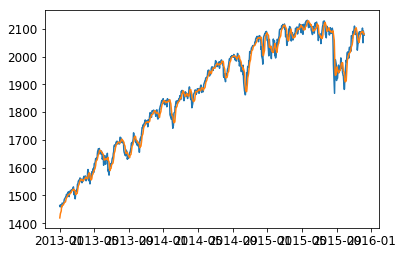

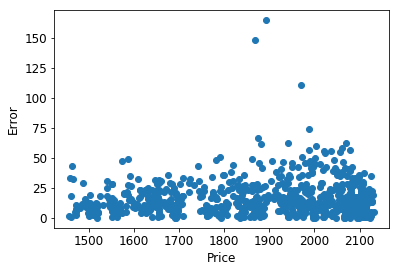

In [14]:
error_metric = 'MAE'
cols = ['avg_5', 'avg_30', 'avg_365']
cols = ['avg_5']
#cols = ['avg_5', 'avg_30', 'avg_365', 'avg_5_over_365', 'std_5', 'std_365', 'std_5_over_365']

model = LinearRegression()
model.fit(train[cols], train['Close'])
predictions = model.predict(test[cols])

if(error_metric == 'MAE'):
    error = mean_absolute_error(test['Close'], predictions)
else:
    error = mean_squared_error(test['Close'], predictions)
    
print(error)

#plt.scatter(test['Close'], np.abs(predictions-test['Close']))
plt.plot(test['Date'], test['Close'])
plt.plot(test['Date'], predictions)

plt.show()

plt.scatter(test['Close'], np.abs(predictions-test['Close']))
plt.xlabel('Price'), plt.ylabel('Error')
plt.show()

Accuracy would improve greatly by making predictions only one day ahead. 

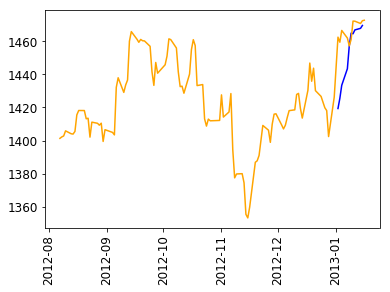

In [15]:
date_init = datetime(year=2013, month=1, day=2)
#create train and test (train everything before 2013-01-01)
train = df[df['Date']<date_init]

cols = ['avg_5', 'avg_30', 'avg_365']
#cols = ['avg_5']
cols = ['avg_5', 'avg_30', 'avg_365', 'avg_5_over_365', 'std_5', 'std_365', 'std_5_over_365']

predictions_list = []
days_list = []

N_days = 10
for i_day in range(0,N_days): 
    test = df.loc[df[df['Date']==date_init].index+i_day]
    days_list.append(test['Date'].values)
    
    model = LinearRegression()
    model.fit(train[cols], train['Close'])
    predictions_list.append(model.predict(test[cols]))


#plt.scatter(test['Close'], np.abs(predictions-test['Close']))
#plt.plot(test['Date'], test['Close'])
plt.plot(days_list, predictions_list, color='blue')

Past_Days = 100
loc = df[df['Date']==date_init].index
plt.plot(df['Date'].loc[loc[0]-Past_Days:loc[0]+N_days], df['Close'].loc[loc[0]-Past_Days:loc[0]+N_days], color='orange')
plt.xticks(rotation=90)
plt.show()

TypeError: invalid type promotion

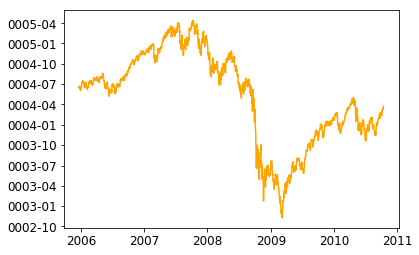

In [16]:
#look at turning points

date_init = datetime(year=2006, month=1, day=6)
#create train and test (train everything before 2013-01-01)

turn_df = pd.DataFrame({'Date' : [], 'Close' : [], 'Turn' : []})
turn_current_df = pd.DataFrame({'Date' : [], 'Close' : [], 'Turn' : []})

#invert if 30 days average is going down

N_days = 1200
#N_days = 100
for i_day in range(0,N_days): 
    current_day = df.loc[df[df['Date']==date_init].index+i_day]
    day_minus_1 = df.loc[df[df['Date']==date_init].index+i_day-1]
    day_minus_2 = df.loc[df[df['Date']==date_init].index+i_day-2]
    day_minus_3 = df.loc[df[df['Date']==date_init].index+i_day-3]
    
    index_start = df[df['Date']==date_init].index[0]+i_day    
    mean_past_200 = np.mean(df['Close'].loc[index_start-200:index_start+i_day])
    mean_past_100 = np.mean(df['Close'].loc[index_start-100:index_start+i_day])
    
    #mean_past_200 = 10
    #mean_past_100 = 20
    
    if(mean_past_100>=mean_past_200):
        if((day_minus_1['Close'].values>=day_minus_2['Close'].values) & 
           (current_day['Close'].values<day_minus_1['Close'].values)):             
            turn_df.loc[i_day] = [current_day['Close'].iloc[0],current_day['Date'].iloc[0],'down']
        
        elif((day_minus_1['Close'].values<=day_minus_2['Close'].values) & 
             (current_day['Close'].values>day_minus_1['Close'].values)):               
            turn_df.loc[i_day] = [current_day['Close'].iloc[0],current_day['Date'].iloc[0],'up']
    else:
         if((day_minus_1['Close'].values>=day_minus_2['Close'].values) & 
           (current_day['Close'].values<day_minus_1['Close'].values)):                   
            turn_df.loc[i_day] = [current_day['Close'].iloc[0],current_day['Date'].iloc[0],'up']
        
         elif((day_minus_1['Close'].values<=day_minus_2['Close'].values) & 
             (current_day['Close'].values>day_minus_1['Close'].values)):               
            turn_df.loc[i_day] = [current_day['Close'].iloc[0],current_day['Date'].iloc[0],'down']

turn_df = turn_df.reset_index(drop=True)
#print(turn_df)

Past_Days = 10
loc = df[df['Date']==date_init].index
plt.plot(df['Date'].loc[loc[0]-Past_Days:loc[0]+N_days], df['Close'].loc[loc[0]-Past_Days:loc[0]+N_days], color='orange')



up = turn_df[turn_df['Turn']=='up']
plt.scatter(up['Date'].values,up['Close'], color='blue', s=20)
down = turn_df[turn_df['Turn']=='down']
plt.scatter(down['Date'].values,down['Close'], color='red', s=20)

print(turn_current_df)

money = 10000
for idx, row in turn_df.iterrows():
    #print(idx)    
    if((idx==0) & (row['Turn']=='down')):
        continue
    else:        
        if(row['Turn']=='up'):
            N_shares = int(money/row['Close'])        
            money = money % row['Close']
        elif(row['Turn']=='down'):
            money = money + N_shares*row['Close']
            N_shares = 0        
    #print(N_shares, money)
        
money += N_shares*row['Close']
print(money)
print((money/10000.-1)*100/(N_days/365.))

loc = df[df['Date']==date_init].index
money = 10000*df['Close'].loc[loc[0]+N_days]/df['Close'].loc[loc[0]]
print(money)
print((money/10000.-1)*100/(N_days/365.))

        
        
    
    

plt.xticks(rotation=90)
plt.show()




Additional features to include:
- The average volume over the past five days.
- The average volume over the past year.
- The ratio between the average volume for the past five days, and the average volume for the past year.
- The standard deviation of the average volume over the past five days.
- The standard deviation of the average volume over the past year.
- The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of - the average volume for the past year.
- The year component of the date.
- The ratio between the lowest price in the past year and the current price.
- The ratio between the highest price in the past year and the current price.
- The year component of the date.
- The month component of the date.
- The day of week.
- The day component of the date.
- The number of holidays in the prior month.

Additional steps:
- Try other techniques, like a random forest.
- You can also incorporate outside data, such as the weather in New York City (where most trading happens) the day before, and the amount of Twitter activity around certain stocks.
- make the system real-time by writing an automated script to download the latest data when the market closes, and make predictions for the next day.
- Finally, you can make the system "higher-resolution". You're currently making daily predictions, but you could make hourly, minute-by-minute, or second by second predictions. This will require obtaining more data, though. You could also make predictions for individual stocks instead of the S&P500.